In [48]:
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.stats import poisson
import openpyxl
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter

### Fragestellung

Diesen Sommer findet wie alle 4 Jahre die Fussball Europameisterschaft statt. Eines der grössten Sportereignisse der Welt. Schon seit Monaten laufen nun Diskusionen, wer sich wohl den Titel holt. Diese Frage haben wir uns auch gestellt und für uns natürlich besonders Interessant, wie hoch ist den die Chance, dass die Schweiz die EM gewinnt?

### Systemdefinition
Faktoren für einen Titelgewinn gibt es unzählige, doch Fussball selbst ist relativ einfach, wer mehr Tore schiesst gewinnt die Partie.

In den meisten Spielen gibt es klare oder weniger klare Favoriten. Wie ein Fussballspiel aber schlussendlich ausgeht ist offen und im voraus nicht vorhersehbar.

Das Turnier hat aber ganz klare bedingungen für einen Titelgewinn:

Qualifikation:
Vor der EM müssen sich Teams überhaupt für die EM qualifizieren. Da die Qualifikation bereits abgeschlossen ist, wissen wir, welche 24 Nationen an der EM 2024 teilnehmen werden.

Gruppenphase:
Die 24 Teams werden in sechs Vierergruppen eingeteilt, diese Spielen dann je einmal gegen jedes andere Team der Gruppe. Pro gewonnener Partie bekommt ein Land drei Punkte, bei einem Unentschieden einen und bei einer Niederlage keinen Punkt. Nachdem die Gruppenphase abgeschlossen ist, Qualifizieren sich jeweils die Gruppenersten und zweiten direkt für den Sechszehntelfinal, zudem Qualifizieren sich noch die vier Besten Gruppendritten ebenfalls. Falls mehrere Teams am Ende gleich viele Punkte haben, zählt die Tordifferenz, dann die Erziehlten Tore.

KO-Phase:
In der KO-Phase geht es immer nur um ein Spiel. Wer gewinnt ist eine Runde weiter und wer verliert ist aus dem Turnier. Wer am Ende den Final gewinnt, ist Europameister.

### Lösungsstrategie
Um die Frage zu beantworten, wie gross die Chancen für die Schweiz sind, wollen wir mithilfe zweier Montecarlosimulation herausfinden. Bei der ersten nehmen wir die Daten des zu diesem Zeitpunkt(01.05.2024) aktuellen ELO-Ratings ([https://www.eloratings.net/]). Bei der Zweiten Simulation verwenden wir die in der Qualifikation geschossenen Tore. Um die Simulationen im Anschluss zurückverfolgen zu können, sollen sie jeweils live in eine Exceldatei übertragen werden.

In [49]:
def write_winner_to_excel(winner, filename):
    try:
        # Load existing workbook, create it if it doesn't exist
        wb = load_workbook(filename)
        ws = wb.active
    except FileNotFoundError:
        # Create a new workbook and worksheet
        wb = openpyxl.Workbook()
        ws = wb.active
        ws.title = "Winners"
        ws.append(["Simulation", "Winner"])  # Add headers

    # Find the next available row
    next_row = ws.max_row + 1

    # Write the simulation number and winner
    ws.cell(row=next_row, column=1, value=next_row - 1)
    ws.cell(row=next_row, column=2, value=winner)

    # Save the workbook
    wb.save(filename)

In [50]:
#Laden der Qualifizierten Teams

data_teams = pd.read_excel("./data/em_teams.xlsx")
data_teams = data_teams.replace('Tschechische Republik', 'Tschechien')
data_teams


,Land,Gruppe
0,Deutschland,A
1,Schottland,A
2,Ungarn,A
3,Schweiz,A
4,Spanien,B
5,Kroatien,B
6,Italien,B
7,Albanien,B
8,Slowenien,C
9,Dänemark,C


## Erste Simulation
Dieses Rating gibt eine sogenannte Elo Zahl heraus. Mit dieser kann relativ einfach die Gewinnwahrscheinlichkeit einer Partie ausgerechnet werden. Genaue Angaben zur Ausrechnung und Aktualisierung der Elo-Wertung sind unter [https://www.eloratings.net/about] aufrufbar. Das Elo-Rating bringt aber ein Problem mit sich, es ist nicht direkt geeignet um Unentschieden Simulieren zu können. Während dies in den KO-Runden kein Problem darstellt, ist es für die Gruppenphase enorm wichtig, zudem braucht es auch da Tore, welche bei gleichstand der Punkte zuhilfe gezogen werden können.

In [51]:
# import elo data as df
data_elo = pd.read_excel("./data/data_elo.xlsx")
data_elo = data_elo.replace('Tschechische Republik', 'Tschechien')
data_elo

,Land,R,Average #,Average R,1 Year Change #,1 Year Change R,Matches T,Matches H,Matches A,Matches N,Matches W,Matches L,Matches D,Goals F,Goals A
0,Afghanistan,1114,167,904,7,20,150,9,57,84,36,79,35,146,312
1,Albanien,1613,73,1499,15,74,383,181,176,26,105,197,81,363,577
2,Algerien,1666,51,1632,-5,-46,650,245,226,179,290,187,173,982,668
3,Andorra,1113,182,1047,3,-8,208,85,93,30,13,167,28,70,505
4,Angola,1508,88,1457,24,101,427,147,173,107,152,128,147,495,440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Westsahara,996,189,996,-3,0,1,0,1,0,0,1,0,0,6
237,Jemen,1094,144,1212,5,2,274,53,81,140,59,165,50,265,561
238,Sambia,1485,60,1559,-6,-1,826,262,342,222,376,237,213,1319,869
239,Sansibar,1326,145,1108,-5,-2,204,27,42,135,37,126,41,169,434


In [52]:
merge_data = pd.merge(data_teams, data_elo, on="Land")
merge_data

,Land,Gruppe,R,Average #,Average R,1 Year Change #,1 Year Change R,Matches T,Matches H,Matches A,Matches N,Matches W,Matches L,Matches D,Goals F,Goals A
0,Deutschland,A,1921,8,1910,-3,-30,1019,451,407,161,587,220,212,2286,1207
1,Schottland,A,1776,14,1878,0,-22,843,392,404,47,401,258,184,1456,1041
2,Ungarn,A,1842,20,1836,3,11,1013,456,485,72,482,315,216,2061,1492
3,Schweiz,A,1804,27,1686,-7,-87,869,414,382,73,308,368,193,1286,1453
4,Spanien,B,2019,7,1942,4,56,753,329,294,130,440,138,175,1517,675
5,Kroatien,B,1953,12,1879,-3,-4,375,147,159,69,196,78,101,647,376
6,Italien,B,1956,8,1916,0,6,878,396,317,165,467,171,240,1536,863
7,Albanien,B,1613,73,1499,15,74,383,181,176,26,105,197,81,363,577
8,Slowenien,C,1739,55,1619,12,61,292,132,134,26,108,111,73,370,344
9,Dänemark,C,1822,20,1798,-2,-32,879,400,388,91,409,292,178,1612,1190


Die Gewinnwahrscheinlichkeit für ein Team bei einem Elosystem berechnet sich mithilfe der Formel:

$$
W_{e} = \frac{1}{10^{-\frac{dr}{400}} + 1}
$$

In [53]:
def win_possiblility(data, country_a, country_b):
    rating_a = data.loc[data["Land"] == country_a, "R"].values[0]
    rating_b = data.loc[data["Land"] == country_b, "R"].values[0]

    dr = rating_a - rating_b
    we = 1 / (10 ** (-dr / 400) + 1)

    return we

Um nun ein Unentschieden zu simulieren y haben wir zuerst die Wahrscheinlichkeit der Unentschieden aus der Elotabelle genommen, indem wir alle Untentschieden durch die Anzahl der Spiele dividiert haben. Wir bekommen so die angabe, dass ca. 22% der Spiele mit einem Gleichstand ausgegangen sind. Im Anschluss mussten wir noch die Geschossenen Tore definieren. Die Tore bei einem Fussballspiel lassen sich mithilfe der Poissonverteilung darstellen [https://www.motapa.de/open/schilling89.pdf]. Nun können wir für jedes Land, welches gewonnen hat eine Passende Toranzahl definieren.

In [54]:
#Um ein unetschieden zu berechnen benötigen wir einen Wert für die wahrscheinlichkeit, dass ein Unentschieden eintritt.
draw_possibility = sum(merge_data["Matches D"])/sum(merge_data["Matches T"])
print(draw_possibility)

#Anzahl der Tore die in einem Spiel fallen können mithilfe der Poisson-Verteilung berechnen
def poisson_pred(data, country):
    country_data = data.loc[data["Land"] == country]
    poisson_pred = country_data["Goals F"].sum() / country_data["Matches T"].sum()

    return poisson_pred

0.2263644667732359


Nun Simulieren wir die beiden arten von Spielen. Während das KO system relativ simpel ist, brauchen wir beim Gruppensystem etwas mehr. Zuerst rechnen wir die Wahrscheinlichkeiten aus, danach noch die Wahrscheinlichkeit für ein Unentschieden, bei diesem haben wir och einen Parameter, welcher die Elodifferenz etwas berücksichtigt. Im Anschluss definieren wir den Gewinner der Partie und weisen den beiden Mannschaften jeweils die erzielten Tore zu.

In [55]:
def simulate_game_ko(data, team_a = str, team_b = str):

    win_pos_a = win_possiblility(data, team_a, team_b)
    if np.random.random() <= win_pos_a:
        win_team = team_a
    else:
        win_team = team_b

    return win_team

#Spiele mit unentschieden simulieren
def simulate_game_group(data, team_a = str, team_b = str):
    rating_a = data.loc[data["Land"] == team_a, "R"].values[0]
    rating_b = data.loc[data["Land"] == team_b, "R"].values[0]
    draw_pos = draw_possibility + 0.06 * (((rating_a - rating_b)/200)**2)  #Annäherung an ein unentschieden mit berücksichtigung der ELO Differenz
    win_pos_a = win_possiblility(data, team_a, team_b) - (draw_pos/2)
    random_number = np.random.random()

    punkte_a = 0
    punkte_b = 0

    if random_number <= draw_pos:
        punkte_a = 1
        punkte_b = 1
        tore_a = np.random.poisson(poisson_pred(data, team_a))
        tore_b = tore_a

    elif random_number <= draw_pos + win_pos_a:
        punkte_a = 3

        tore_a = np.random.poisson(poisson_pred(data, team_a))
        while tore_a == 0:
            tore_a = np.random.poisson(poisson_pred(data, team_a))

        tore_b = np.random.poisson(poisson_pred(data, team_b))
        if tore_b >= tore_a:
            tore_b = tore_a - np.random.randint(1, tore_a+1)
            
    else:
        punkte_b = 3

        tore_b = np.random.poisson(poisson_pred(data, team_b))
        while tore_b == 0:
            tore_b = np.random.poisson(poisson_pred(data, team_b))
            
        tore_a = np.random.poisson(poisson_pred(data, team_a))
        if tore_a >= tore_b:
            tore_a = tore_b - np.random.randint(1, tore_b+1)
        

    return punkte_a, punkte_b, tore_a, tore_b


test = simulate_game_group(merge_data, "Schweiz", "Deutschland")
test

(0, 3, 1, 3)

Nun werden nur noch die Gruppen simuliert und die Ergebnisse in einer Tabelle gespeichert. Nach den Gruppenspielen werden die Teams in die KO-Runde überführt. Und am Ende kann das Ganze Tounament Simuliert werden. Sobald dies Gemacht ist erwetern wir die Simulation auf viele Tourniere und schauen am ende, wer wievielmal gewonnen hat.

In [56]:
def simulate_group(data, group=str):
    # DataFrame für die spezifische Gruppe filtern
    filtered_df = data_teams[data_teams['Gruppe'] == group].copy()

    # Neue Spalten für Punkte und Tordifferenz hinzufügen und auf Null initialisieren
    filtered_df.loc[:, 'points'] = 0
    filtered_df.loc[:, 'goals_diff'] = 0
    filtered_df.loc[:, 'goals_for'] = 0
    filtered_df.loc[:, 'goals_against'] = 0

    # Iteriere über alle Kombinationen von Ländern innerhalb der Gruppe und simuliere jedes Spiel
    for country_a, country_b in combinations(filtered_df['Land'], 2):
        punkte_a, punkte_b, tore_a, tore_b = simulate_game_group(data, country_a, country_b)
        
        # Punkte und Tordifferenz für jedes Land aktualisieren
        filtered_df.loc[filtered_df['Land'] == country_a, 'points'] += punkte_a
        filtered_df.loc[filtered_df['Land'] == country_b, 'points'] += punkte_b
        filtered_df.loc[filtered_df['Land'] == country_a, 'goals_diff'] += tore_a - tore_b
        filtered_df.loc[filtered_df['Land'] == country_b, 'goals_diff'] += tore_b - tore_a
        filtered_df.loc[filtered_df['Land'] == country_a, 'goals_for'] += tore_a
        filtered_df.loc[filtered_df['Land'] == country_a, 'goals_against'] += tore_b
        filtered_df.loc[filtered_df['Land'] == country_b, 'goals_for'] += tore_b
        filtered_df.loc[filtered_df['Land'] == country_b, 'goals_against'] += tore_a

    # Sortiere die Länder nach Punkten und Tordifferenz
    filtered_df = filtered_df.sort_values(by=['points', 'goals_diff', 'goals_for', 'goals_against'], ascending=False).reset_index(drop=True)

    return filtered_df

test = simulate_group(merge_data, "E")
print(test)

       Land Gruppe  points  goals_diff  goals_for  goals_against
0   Ukraine      E       6           2          6              4
1   Belgien      E       5           1          5              4
2  Slowakei      E       4          -1          5              6
3  Rumänien      E       1          -2          3              5


In [57]:
def get_wildcard(groups: list):
    # Erzeuge eine Liste mit den Gruppendritten
    third_place = []
    for group in groups:
        third_place.append(group.iloc[2])
    third_place = sorted(third_place, key=lambda x: (x['points'], x['goals_diff'], x['goals_for'], x['goals_against']), reverse=True)
    
    third_place = [team['Land'] for team in third_place]
    return third_place

In [58]:
def octa_round(data):
    #Get every group
    group_a = simulate_group(data, "A")
    group_b = simulate_group(data, "B")
    group_c = simulate_group(data, "C")
    group_d = simulate_group(data, "D")
    group_e = simulate_group(data, "E")
    group_f = simulate_group(data, "F")

    #Get 4 extra teams (3rd place)
    wildcard1 = get_wildcard([group_a, group_d, group_e, group_f])[0]
    wildcard2 = get_wildcard([group_a, group_b, group_c])[0]
    if wildcard1 == wildcard2:
        wildcard2 = get_wildcard([group_a, group_b, group_c])[1]

    wildcard3 = get_wildcard([group_a, group_b, group_c, group_d])[0]
    if wildcard3 == wildcard1 or wildcard3 == wildcard2:
        wildcard3 = get_wildcard([group_a, group_b, group_c, group_d])[1]
        if wildcard3 == wildcard1 or wildcard3 == wildcard2:
            wildcard3 = get_wildcard([group_a, group_b, group_c, group_d])[2]
    
    wildcard4 = get_wildcard([group_d, group_e, group_f])[0]
    if wildcard4 == wildcard1 or wildcard4 == wildcard2 or wildcard4 == wildcard3:
        wildcard4 = get_wildcard([group_d, group_e, group_f])[1]
        if wildcard4 == wildcard1 or wildcard4 == wildcard2 or wildcard4 == wildcard3:
            wildcard4 = get_wildcard([group_d, group_e, group_f])[2]


    group_a = group_a['Land'].tolist()
    group_b = group_b['Land'].tolist()
    group_c = group_c['Land'].tolist()
    group_d = group_d['Land'].tolist()
    group_e = group_e['Land'].tolist()
    group_f = group_f['Land'].tolist()

    octa_final_1 = simulate_game_ko(data, group_b[0], wildcard1)
    octa_final_2 = simulate_game_ko(data, group_a[0], group_c[1])
    octa_final_3 = simulate_game_ko(data, group_f[0], wildcard2)
    octa_final_4 = simulate_game_ko(data, group_d[1], group_e[1])
    octa_final_5 = simulate_game_ko(data, group_e[0], wildcard3)
    octa_final_6 = simulate_game_ko(data, group_d[0], group_f[1])
    octa_final_7 = simulate_game_ko(data, group_c[0], wildcard4)
    octa_final_8 = simulate_game_ko(data, group_a[1], group_b[1])

    octa_finals = [octa_final_1, octa_final_2, octa_final_3, octa_final_4, octa_final_5, octa_final_6, octa_final_7, octa_final_8]

    return octa_finals



test = octa_round(merge_data)
print(test)

['Spanien', 'Ungarn', 'Georgien', 'Niederlande', 'Kroatien', 'Frankreich', 'England', 'Italien']


In [59]:
def quater_round(data, octa_finals):
    quater_final_1 = simulate_game_ko(data, octa_finals[0], octa_finals[1])
    quater_final_2 = simulate_game_ko(data, octa_finals[2], octa_finals[3])
    quater_final_3 = simulate_game_ko(data, octa_finals[4], octa_finals[5])
    quater_final_4 = simulate_game_ko(data, octa_finals[6], octa_finals[7])

    quater_finals = [quater_final_1, quater_final_2, quater_final_3, quater_final_4]

    return quater_finals

test_quater = quater_round(merge_data, test)
print(test_quater)

['Spanien', 'Niederlande', 'Frankreich', 'England']


In [60]:
def half_round(data, quater_finals):
    half_final_1 = simulate_game_ko(data, quater_finals[0], quater_finals[1])
    half_final_2 = simulate_game_ko(data, quater_finals[2], quater_finals[3])

    half_finals = [half_final_1, half_final_2]

    return half_finals

test_half = half_round(merge_data, test_quater)
print(test_half)

['Niederlande', 'Frankreich']


In [61]:
def final_round(data, half_finals):
    final = simulate_game_ko(data, half_finals[0], half_finals[1])

    return final

test_final = final_round(merge_data, test_half)
print(test_final)

Frankreich


In [62]:
def simulate_tournament(data):
    octa_finals = octa_round(data)
    quater_finals = quater_round(data, octa_finals)
    half_finals = half_round(data, quater_finals)
    final = final_round(data, half_finals)

    return final

test_tournament = simulate_tournament(merge_data)
print(test_tournament)

Niederlande


In [63]:
def multiple_simulations(data, n, filename):
    winner_dict = {}

    for i in range(n):
        winner = simulate_tournament(data)
        write_winner_to_excel(winner, filename)
        
        if winner not in winner_dict:
            winner_dict[winner] = 1
        else:
            winner_dict[winner] += 1
        
    return winner_dict

Nun können wir Torunamente simulieren und ausgeben.

In [64]:
n = 10000
lst_elo = multiple_simulations(merge_data, n, filename='tournament_winners_ELO1.xlsx')
print(lst_elo)

{'Portugal': 9, 'Frankreich': 13, 'Spanien': 4, 'Kroatien': 4, 'England': 8, 'Ungarn': 1, 'Niederlande': 4, 'Italien': 2, 'Deutschland': 2, 'Belgien': 2, 'Dänemark': 1}


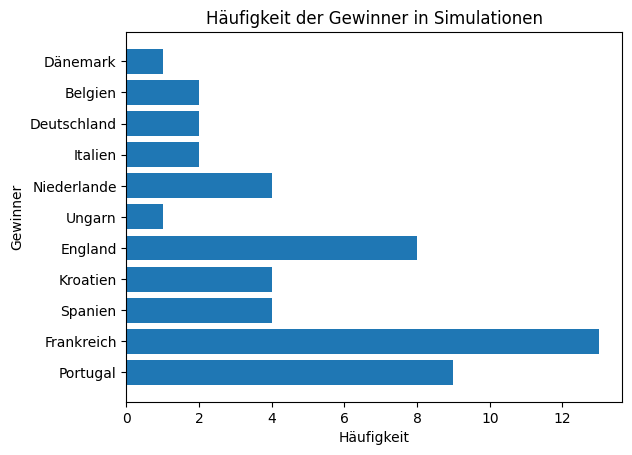

In [65]:
plt.barh(list(lst_elo.keys()), lst_elo.values())  # Horizontaler Balkendiagramm
plt.xlabel('Häufigkeit')
plt.ylabel('Gewinner')
plt.title('Häufigkeit der Gewinner in Simulationen')
plt.show()

C:\Users\Adrian Meier\AppData\Local\Temp\ipykernel_7880\3623486421.py:9: RuntimeWarning: invalid value encountered in scalar divide
  percentage = (count_schweiz / i) * 100


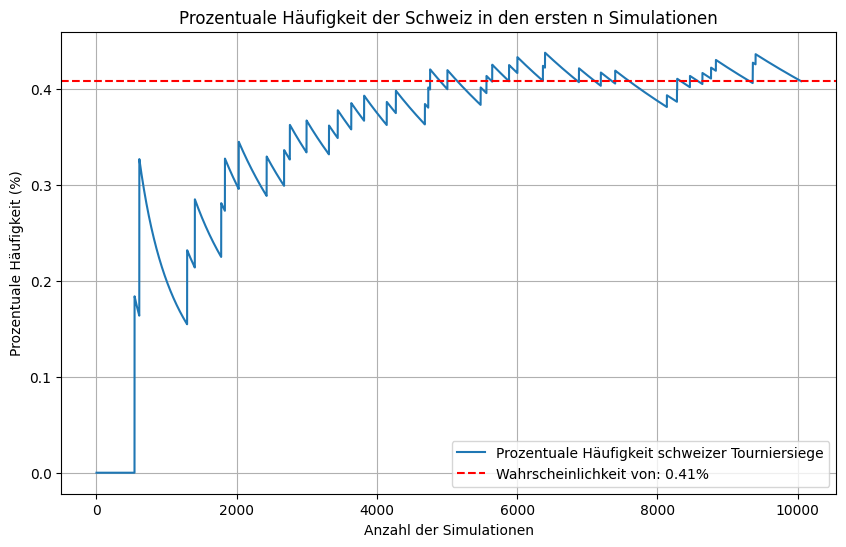

In [77]:
simulated_data_elo = pd.read_excel('tournament_winners_ELO.xlsx')

def plot_häufigkeit(data):
    percentages = []

    for i in range(len(data)):
        current_slice = data["Winner"][:i]
        count_schweiz = current_slice[current_slice == 'Schweiz'].count()
        percentage = (count_schweiz / i) * 100
        percentages.append(percentage)

    last_percentage = percentages[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(data) + 1), percentages, label='Prozentuale Häufigkeit schweizer Tourniersiege')
    plt.axhline(y=percentages[-1], color='r', linestyle='--', label=f'Wahrscheinlichkeit von: {percentages[-1]:.2f}%')
    plt.xlabel('Anzahl der Simulationen')
    plt.ylabel('Prozentuale Häufigkeit (%)')
    plt.title('Prozentuale Häufigkeit der Schweiz in den ersten n Simulationen')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_häufigkeit(simulated_data_elo)

In [73]:
print("Chance das die Schweiz die EM gewinnt liegt bei:", lst_elo["Schweiz"]/n * 100, "%")
print("Anzahl der Simulationen:", n)

KeyError: 'Schweiz'

## Zweite Simulation

Für die Zweite SImulation verwenden wir anstelle der Elozahl die Geschossenen Tore aus den Letzten vier EM Qualifikationen.

Warum nur die EM Qualifikationen?

Dies hat zwei Gründe: Der erste ist, dass nicht alle Teams bereits an einer Endrunde waren, und wir deshalb von einigen Teams keine Daten für Endspiele haben. Der Zweit Grund ist, dass die Gruppen in der EM Qualifikation sehr ausgeglichen sind und der Wettbewerb trotzdem ernstgenommen wird. Uns ist dabei bewusst, das in der Qualifikation oftmals mehr Tore erzielt werden, als an der EM. Dies spielt für unsere Simulation aber weniger eine Rolle, da wir annehmen, dass die alle Teams in der Qualifikation mehr Tore schiessen als an der Endrunde. Und ob ein Spiel dann mit 7:5 oder 2:1 endet ist für die Simulation erstmal weniger relevant.

Im vergleich zum ersten Model können wir gerade in den Gruppenphasen mithilfe der Zufallsvariablen bessere Spiele generieren. Ein Unentschieden wird nun durch tatsächliche Tore repräsentiert. Der Nachteil zum ersten Modell ist, dass bei der Elo Wertung mehr Werte einbezogen werden, und wir nun bei diesem Modell nur die geschossenen Tore betrachten.

In [ ]:
data_goals_23 = pd.read_excel("./data/EM quali 22 23.xlsx", header=None, names=["Land", "Tore"])
data_goals_19 = pd.read_excel("./data/EM quali 18 19.xlsx", header=None, names=["Land", "Tore"])
data_goals_15 = pd.read_excel("./data/EM quali 14 15.xlsx", header=None, names=["Land", "Tore"])
data_goals_11 = pd.read_excel("./data/EM quali 10 11.xlsx", header=None, names=["Land", "Tore"])

data_goals_merged = pd.concat([data_goals_23, data_goals_19, data_goals_15, data_goals_11], ignore_index=True)
data_goals_merged = data_goals_merged[data_goals_merged['Land'].isin(data_teams['Land'])]
print(data_goals_merged)


            Land  Tore
0     Schottland     3
1        Spanien     3
2       Georgien     1
3     Schottland     2
6     Schottland     2
...          ...   ...
1873  Tschechien     2
1876     Spanien     2
1877  Schottland     1
1878  Tschechien     4
1879  Schottland     1

[798 rows x 2 columns]


In [ ]:
data_goals = {}

for land, tore in data_goals_merged.groupby('Land')['Tore']:
    # Die Tore als Liste speichern
    data_goals[land] = list(tore)

An einem kleinen Beispiel von England können wir gut sehen, wie die Poissen-Verteilung passend für die Anzahl geschossener Tore passt.

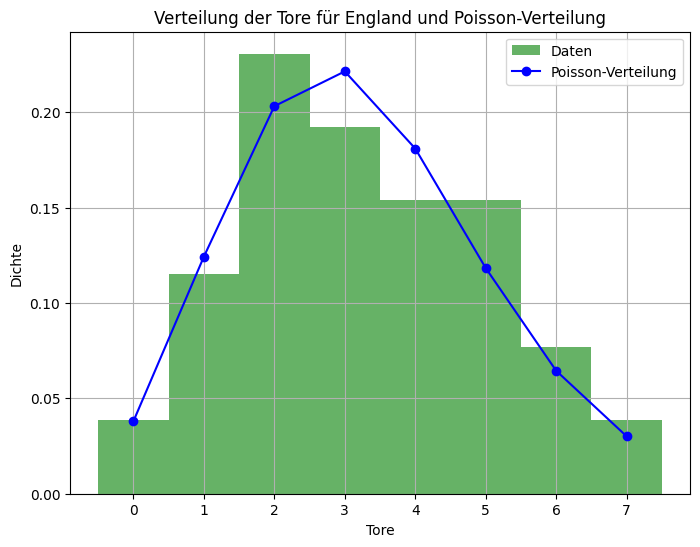

In [ ]:
# Histogramm für ein Land erstellen
land = 'England'
tore = data_goals[land]

# Bestimme die maximale Anzahl von Toren
max_tore = max(tore)

# Schätze die Parameter der Poisson-Verteilung
mu = np.mean(tore)

# Erzeuge eine Poisson-Verteilung mit den geschätzten Parametern
poisson_dist = poisson(mu)

# Erzeuge das Histogramm der Tore
plt.figure(figsize=(8, 6))
plt.hist(tore, bins=max_tore+1, range=(-0.5, max_tore+0.5), density=True, alpha=0.6, color='g', label='Daten')

# Erzeuge die Poisson-Verteilungskurve
x_values = np.arange(0, max_tore+1)
plt.plot(x_values, poisson_dist.pmf(x_values), 'bo-', label='Poisson-Verteilung')

# Diagrammbeschriftung
plt.title(f'Verteilung der Tore für {land} und Poisson-Verteilung')
plt.xlabel('Tore')
plt.ylabel('Dichte')
plt.legend()
plt.grid(True)
plt.show()

Nun werden auch in dieser Simulation mithilfe der Daten und der Poissonverteilung die Spiele Simuliert.

In [ ]:
#Gewinner durch Poisson-Verteilung
def win_goals(data, country_a, country_b):
    mu_a = np.mean(data[country_a])
    mu_b = np.mean(data[country_b])

    poisson_dist_a = poisson(mu_a)
    poisson_dist_b = poisson(mu_b)

    tore_a = poisson_dist_a.rvs()
    tore_b = poisson_dist_b.rvs()

    return tore_a, tore_b


In [ ]:
def simulate_game_group(data, country_a, country_b):
    tore_a, tore_b = win_goals(data, country_a, country_b)
    punkte_a = 0
    punkte_b = 0
    if tore_a > tore_b:
        punkte_a = 3
    elif tore_a < tore_b:
        punkte_b = 3
    else:
        punkte_a = 1
        punkte_b = 1

    return punkte_a, punkte_b, tore_a, tore_b

def simulate_game_ko(data, country_a, country_b):
    while True:
        tore_a, tore_b = win_goals(data, country_a, country_b)
        if tore_a > tore_b:
            return country_a
        elif tore_a < tore_b:
            return country_b
        else:
            continue



In [ ]:
test = simulate_group(data_goals, "E")
print(test)




       Land Gruppe  points  goals_diff  goals_for  goals_against
0  Rumänien      E       7           3         10              7
1  Slowakei      E       4           0          5              5
2   Belgien      E       3          -1          9             10
3   Ukraine      E       3          -2          8             10


In [ ]:
test = octa_round(data_goals)
print(test)
test_quater = quater_round(data_goals, test)
print(test_quater)
test_half = half_round(data_goals, test_quater)
print(test_half)
test_final = final_round(data_goals, test_half)
print(test_final)

['Spanien', 'Deutschland', 'Türkei', 'Polen', 'Schweiz', 'Tschechien', 'England', 'Schottland']
['Spanien', 'Polen', 'Schweiz', 'England']
['Spanien', 'Schweiz']
Schweiz


In [ ]:
n = 10000
lst_goal = multiple_simulations(data_goals, n, filename='tournament_winners_GOALS1.xlsx')
print(lst_goal)

{'Belgien': 1070, 'England': 1995, 'Niederlande': 1013, 'Portugal': 881, 'Frankreich': 172, 'Deutschland': 1647, 'Spanien': 1191, 'Schweiz': 254, 'Schottland': 81, 'Italien': 538, 'Polen': 303, 'Österreich': 163, 'Kroatien': 129, 'Ukraine': 83, 'Tschechien': 87, 'Slowenien': 61, 'Georgien': 4, 'Dänemark': 141, 'Albanien': 15, 'Rumänien': 27, 'Serbien': 38, 'Slowakei': 26, 'Ungarn': 36, 'Türkei': 45}


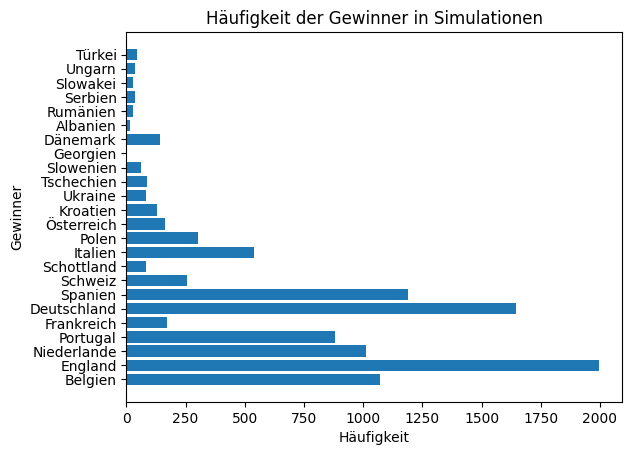

In [ ]:
plt.barh(list(lst_goal.keys()), lst_goal.values())  # Horizontaler Balkendiagramm
plt.xlabel('Häufigkeit')
plt.ylabel('Gewinner')
plt.title('Häufigkeit der Gewinner in Simulationen')
plt.show()

Wahrscheinlichkeit der Schweizer Tournierchancen mit der Anzahl der Simulationen vergleichen.

C:\Users\Adrian Meier\AppData\Local\Temp\ipykernel_7880\3623486421.py:9: RuntimeWarning: invalid value encountered in scalar divide
  percentage = (count_schweiz / i) * 100


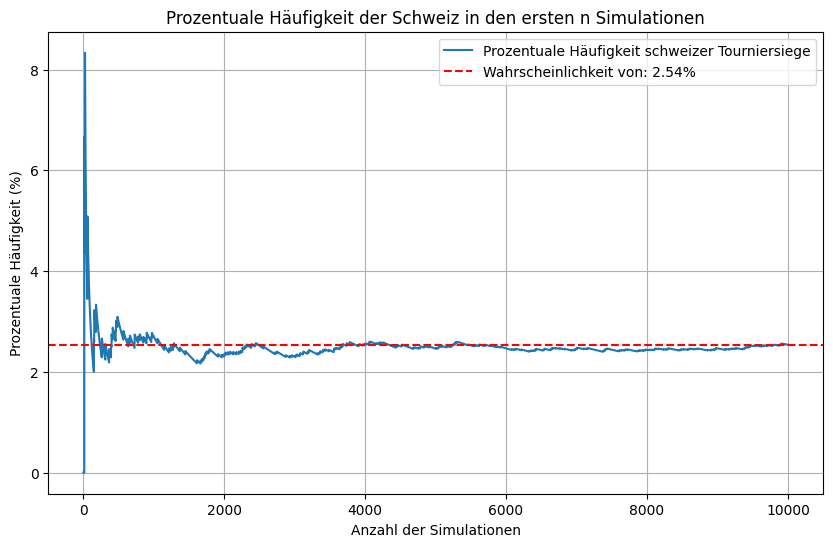

In [78]:
simulated_data_goal = pd.read_excel('tournament_winners_GOALS.xlsx')

plot_häufigkeit(simulated_data_goal)

In [ ]:
print("Chance das die Schweiz die EM gewinnt liegt bei:", lst_goal["Schweiz"]/n * 100, "%")
print("Anzahl der Simulationen:", n)

Chance das die Schweiz die EM gewinnt liegt bei: 2.54 %
Anzahl der Simulationen: 10000


### Auswertung

Durch unsere Simulation können wir sagen, dass die Chancen der Schweiz dieses Jahr einen EM Titel zu gewinnen sehr klein aber nicht Null sind. Wir kommen etwa auf 2-3%. Dabei haben wir keinen markanten Unterschied zwischen den beiden Simulationen gefunden, zumindest wenn es um die Schweiz geht. Bei den Top Kandidaten gibt es zum Teil deutlichere Unterschiede zwischen den beiden Modellen. Zudem haben mit der zweiten Simulation die "schlechteren" Teams eine Etwas bessere Chance als bei der Ersten.

### Reflexion

Wir haben in diesem Projekt viel über die Montecarlosimulation gelehrt und wie wir Verteilungen und Zufallsvariablen anwenden können. Unsere Simulationen haben an einigen Stellen noch verbesserungspotential. Der Code könnte sicher noch an einigen Stellen optimiert werden, sodass die Simulationen schneller laufen. Zudem mussten wir an einigen Orten Kompromisse eingehen, wie zum Beispiel bei den Unentschieden in der Elo-Simulation oder das wir nur die EM Qualifikation als Grundlage für die zweite Simulation verwendet haben. Die Ergebnisse könnten durch mehr und genauere Eingaben sicherlich noch präzisiert werden. Trozdem haben wir das gefühl, dass unsere Frage vom Beginn beantwortet werden kann.